In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arch
import os

temp = os.getcwd()
print(f'Current working directory: {temp}')
if '/project2' in temp:
    temp = temp.replace('/project2', '')
    os.chdir(temp)
    print(f'Switched to: {temp}')

Current working directory: /Users/marco/dev/time-series


In [9]:
def import_stocks(name):
    dataframe = pd.read_excel('data/'+str(name)+'.xlsx', header=3, index_col='Date')
    dataframe.index = pd.to_datetime(dataframe.index)
    return dataframe

names = ['EDP RENOVAVEISprice', 'GALP ENERGIA-NOMprice', 'MOTA ENGILprice', 'NOSSGPSprice', 'NOVABASESGPSprice']

edp = import_stocks(names[0])
galp = import_stocks(names[1])
mota = import_stocks(names[2])
noss = import_stocks(names[3])
nova = import_stocks(names[4])


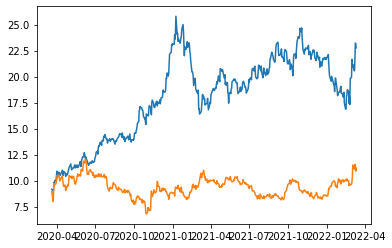

In [10]:

plt.plot(edp.index, edp.Open)
plt.plot(galp.index, galp.Open)
plt.plot()
plt.show()

In [11]:
def calc_log_returns(df):
    log_returns = []
    for idx in range(1,df.shape[0]):
        log_returns.append(np.log(df.Close[idx])-np.log(df.Close[idx-1]))
    return log_returns

edp_log_returns = calc_log_returns(edp)
galp_log_returns = calc_log_returns(galp)
mota_log_retuns = calc_log_returns(mota)
noss_log_returns = calc_log_returns(noss)
nova_log_returns = calc_log_returns(nova)


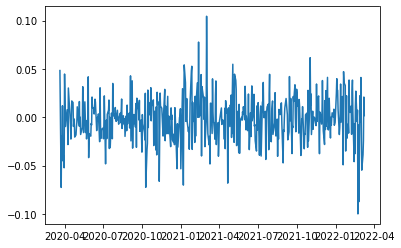

In [12]:
plt.plot(edp.index[1:], edp_log_returns)
plt.show()

In [13]:
galp

,Open,High,Low,Close,Number of Shares,Number of Trades,Turnover,vwap
Date,,,,,,,,
2022-03-11,11.170,11.415,11.050,11.245,3007608,4829,33762945,11.2258
2022-03-10,10.900,11.280,10.760,11.160,3656386,6109,40542452,11.0881
2022-03-09,11.560,11.750,10.610,10.940,5966265,8966,65606677,10.9963
2022-03-08,11.525,11.915,11.460,11.490,5107465,7280,59242627,11.5992
2022-03-07,11.100,11.895,10.975,11.490,5452646,8240,62691174,11.4974
...,...,...,...,...,...,...,...,...
2020-03-26,9.476,9.800,9.430,9.800,3140704,5360,30404141,9.6807
2020-03-25,9.708,10.240,9.254,9.622,4567175,7711,43993196,9.6325
2020-03-24,8.640,9.394,8.500,9.394,3937184,6814,35845625,9.1044
